In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/img.zip

In [ ]:
!pip install fastai

In [4]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc 
import pandas as pd
import fastai

%matplotlib inline

In [5]:
data = ImageDataLoaders.from_csv(path='',
                                 csv_fname='train_label.csv',
                                 label_col='category_name',  # Assuming you want to use category_name as label
                                 fn_col='image_name', 
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42),
                                 num_workers=0)

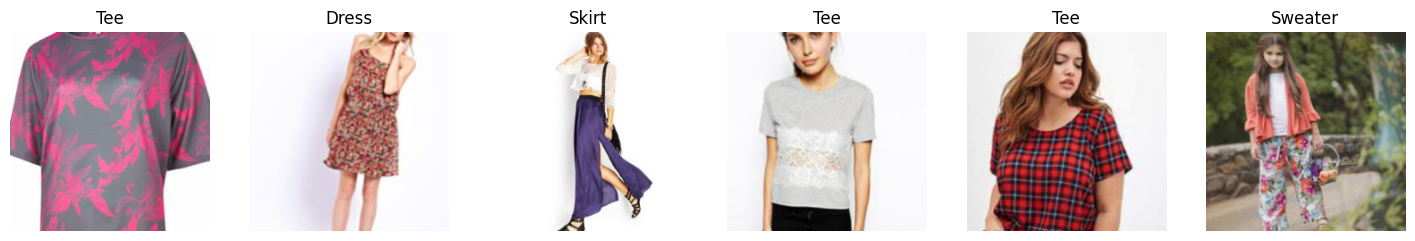

In [6]:
data.show_batch(max_n=6, nrows=1)

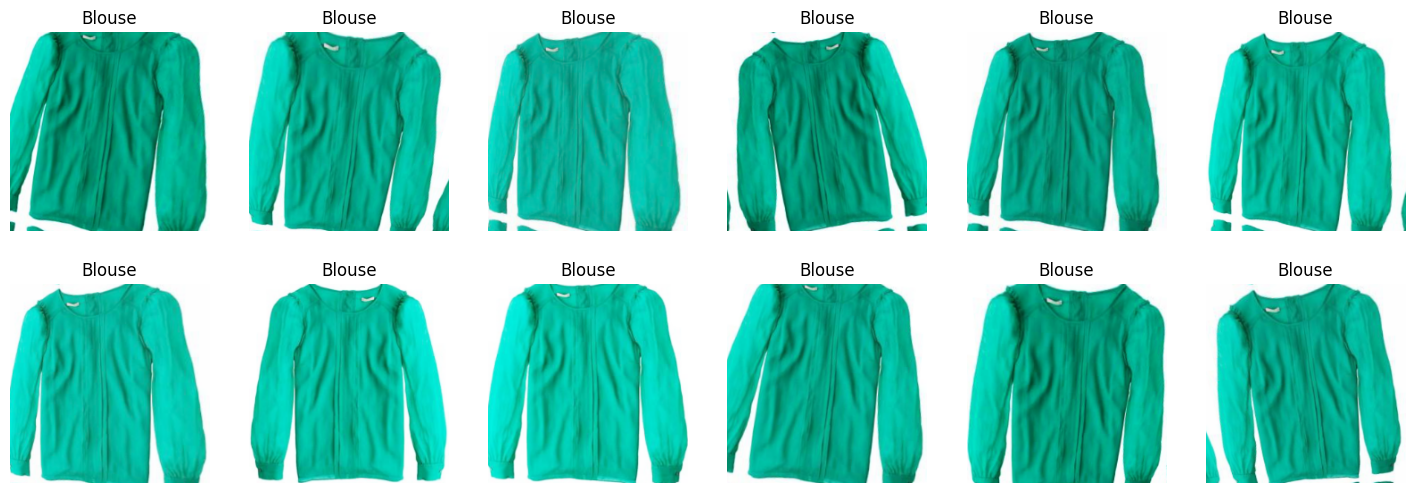

In [7]:
data.show_batch(max_n=12, nrows=2, unique=True)

In [11]:
# Create a Convolutional Neural Network learner with a ResNet34 architecture
model = cnn_learner(dls=data, arch=densenet201, loss_func=CrossEntropyLossFlat(), metrics=accuracy, pretrained=False)

# Fine-tune the model for 2 epochs
model.fine_tune(epochs=2)

# Save the trained model with a name
model.save('stage-1_densenet201')

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,2.559481,2.429567,0.310869,23:18


epoch,train_loss,valid_loss,accuracy,time
0,2.057380,1.934836,0.433945,25:49
1,1.859930,1.730499,0.487143,25:51


Path('models/stage-1_densenet201.pth')

In [12]:
gc.collect()
torch.cuda.empty_cache()

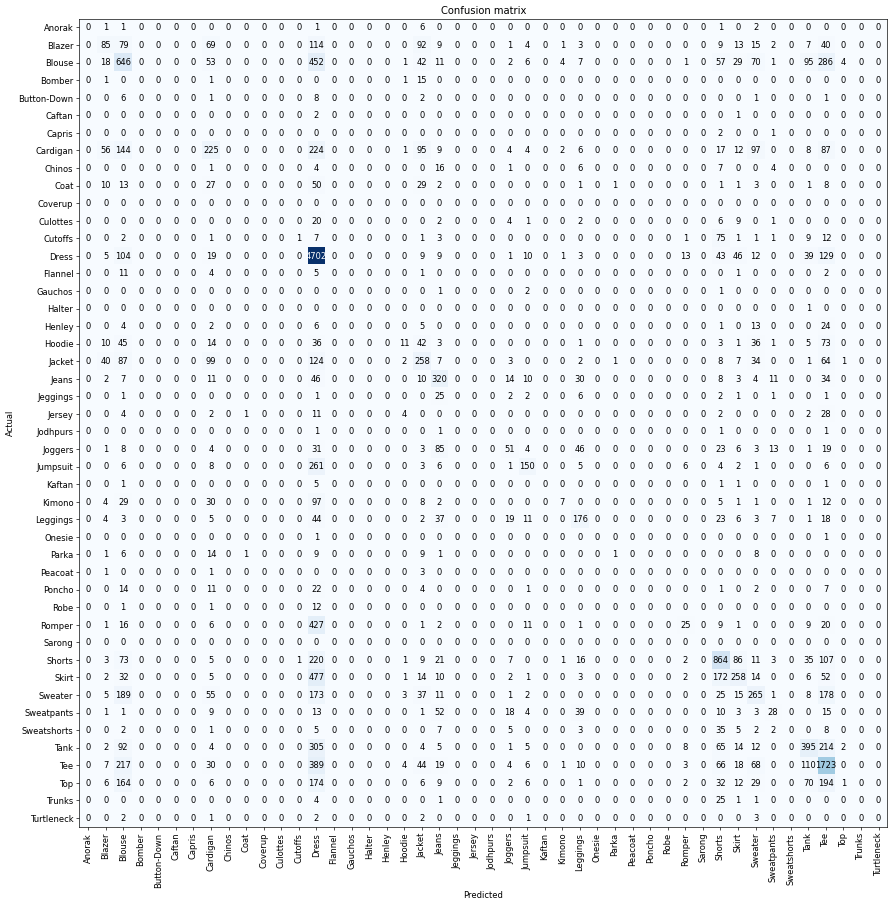

In [14]:
# Create a classification interpretation object from the learner
classification_interpreter = ClassificationInterpretation.from_learner(model)

# Define the size and resolution of the confusion matrix
confusion_matrix_dimensions = (15,15)
resolution = 60

# Plot the confusion matrix
classification_interpreter.plot_confusion_matrix(figsize=confusion_matrix_dimensions, dpi=resolution)

In [15]:
# Determine the most confused classes with a minimum value of 70
classification_interpreter.most_confused(min_val=70)

[('Skirt', 'Dress', 477),
 ('Blouse', 'Dress', 452),
 ('Romper', 'Dress', 427),
 ('Tee', 'Dress', 389),
 ('Tank', 'Dress', 305),
 ('Blouse', 'Tee', 286),
 ('Jumpsuit', 'Dress', 261),
 ('Cardigan', 'Dress', 224),
 ('Shorts', 'Dress', 220),
 ('Tee', 'Blouse', 217),
 ('Tank', 'Tee', 214),
 ('Top', 'Tee', 194),
 ('Sweater', 'Blouse', 189),
 ('Sweater', 'Tee', 178),
 ('Top', 'Dress', 174),
 ('Sweater', 'Dress', 173),
 ('Skirt', 'Shorts', 172),
 ('Top', 'Blouse', 164),
 ('Cardigan', 'Blouse', 144),
 ('Dress', 'Tee', 129),
 ('Jacket', 'Dress', 124),
 ('Blazer', 'Dress', 114),
 ('Tee', 'Tank', 110),
 ('Shorts', 'Tee', 107),
 ('Dress', 'Blouse', 104),
 ('Jacket', 'Cardigan', 99),
 ('Cardigan', 'Sweater', 97),
 ('Kimono', 'Dress', 97),
 ('Blouse', 'Tank', 95),
 ('Cardigan', 'Jacket', 95),
 ('Blazer', 'Jacket', 92),
 ('Tank', 'Blouse', 92),
 ('Cardigan', 'Tee', 87),
 ('Jacket', 'Blouse', 87),
 ('Shorts', 'Skirt', 86),
 ('Joggers', 'Jeans', 85),
 ('Blazer', 'Blouse', 79),
 ('Cutoffs', 'Shorts', 75

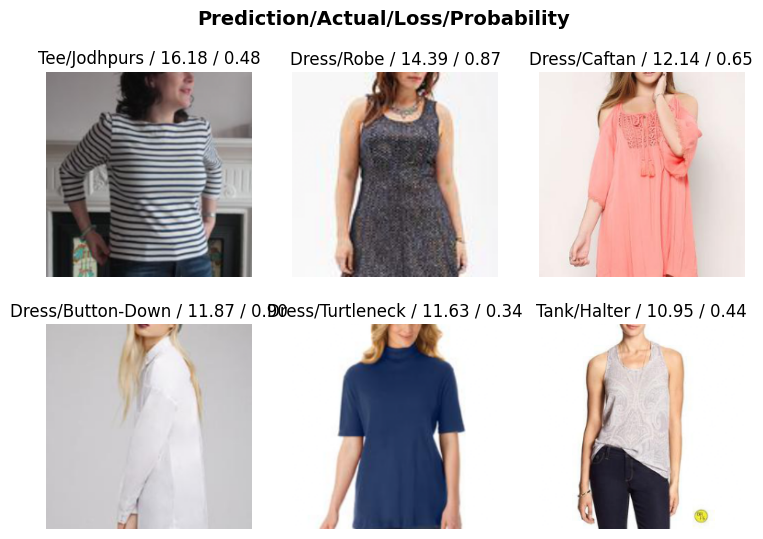

In [16]:
# Visualize the top 6 losses in a grid with 2 rows
classification_interpreter.plot_top_losses(6, nrows=2)

In [17]:
# Now you want to unfreeze and continue training
model.unfreeze()

SuggestedLRs(minimum=9.12010818865383e-08, steep=7.585775847473997e-07, valley=2.511886486900039e-05, slide=0.0063095735386013985)

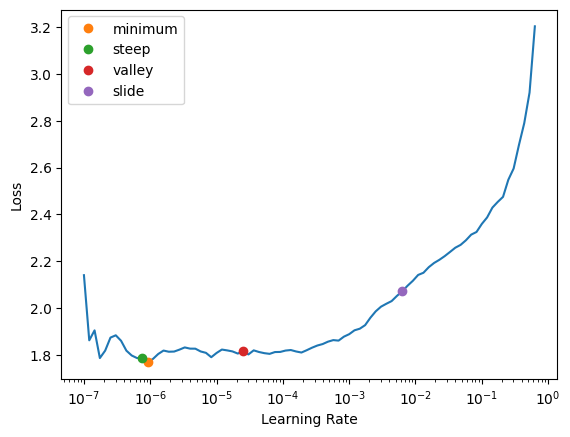

In [18]:
model.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [19]:
model.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.816991,1.709561,0.494886,25:57
1,1.759338,1.676083,0.503537,25:57


KeyboardInterrupt: ignored

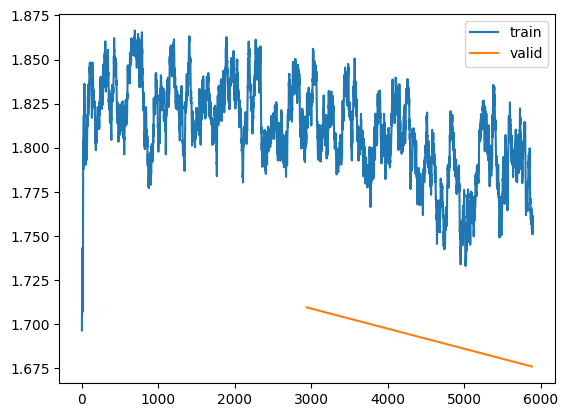

In [20]:
model.recorder.plot_loss()

In [21]:
modelname = model.model
modelname.cpu()
torch.save(modelname, 'bn_resnet34.pkl')

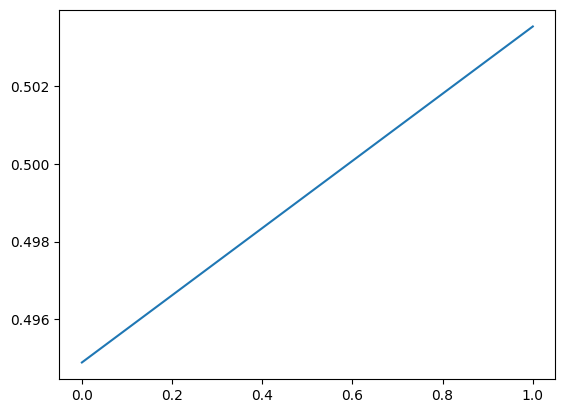

In [22]:
plt.plot(L(model.recorder.values).itemgot(2))

epoch,train_loss,valid_loss,accuracy,time
0,1.816991,1.709561,0.494886,25:57
1,1.759338,1.676083,0.503537,25:57


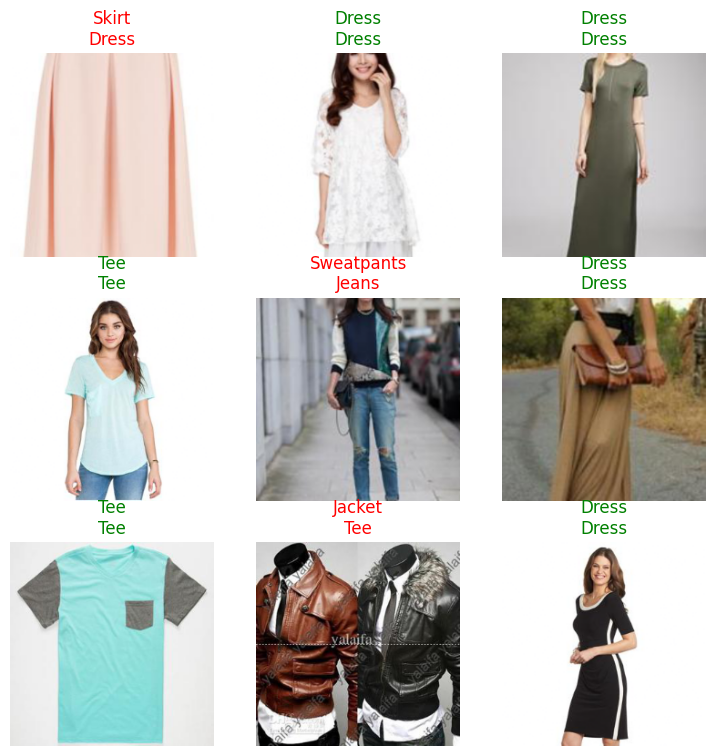

In [23]:
model.show_results()

In [24]:
test_img_data = ImageDataLoaders.from_csv('', csv_fname='test_label.csv',
                                 label_col='category_name',  # Assuming you want to use category_name as label
                                 fn_col='image_name',
                                 item_tfms=Resize(224), 
                                 #batch_tfms=Normalize.from_stats(*imagenet_stats),
                                 num_workers=0)

In [25]:
model.data = test_img_data
model.validate()

(#2) [1.6765861511230469,0.5016250610351562]

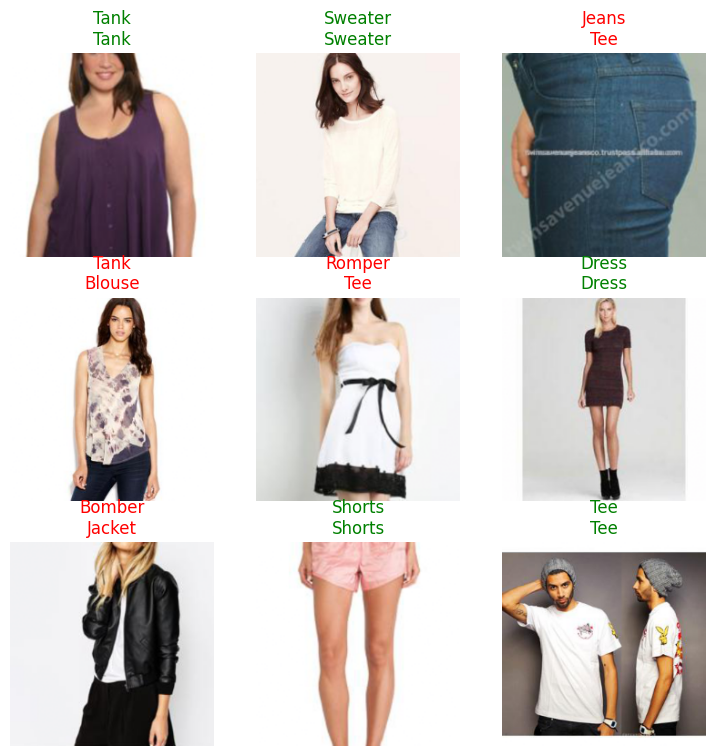

In [28]:
model.show_results()

In [26]:
def top_k_accuracy(pred, truth, k_values=(3,)):
    """Calculates the top-k accuracy for specified values of k"""

    highest_k = max(k_values)
    num_samples = truth.size(0)

    _, predictions = pred.topk(highest_k, 1, True, True)
    predictions = predictions.transpose(0, 1)
    correct_predictions = predictions.eq(truth.view(1, -1).expand_as(predictions))

    result = []
    for k in k_values:
        #print(correct_predictions[:k].contiguous().view(-1))
        correct_k = correct_predictions[:k].reshape(-1).float().sum(0, keepdim=True)
        result.append(correct_k.mul_(100.0 / num_samples))
    return result


In [27]:
output, target = model.get_preds()

In [29]:
print(top_k_accuracy(pred=output, truth=target))

[tensor([74.1946])]


In [30]:
print(top_k_accuracy(pred=output, truth=target, k_values=(5,)))

[tensor([83.9881])]


In [31]:
model.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 56 x 56  
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
ReLU                                                           
___________________________________